Import der benötigten Module. Das Modul "ecgdetectors" wird zuerst heruntergeladen und installiert.

In [1]:
from google.colab import files
import csv
import scipy.io as sio
import matplotlib.pyplot as plt
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split
from keras.utils import np_utils
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf
nb_classes = 2

Upload-Dialog, um die EKG-Daten in die virtuelle Maschine zu laden und zu entpacken (es erfolgt keine Prüfung, ob die richtige Datei hochgeladen wurde)

In [2]:
uploaded = files.upload()
!unzip training.zip

Die letzten 5000 Zeilen der Streamingausgabe wurden abgeschnitten.
  inflating: training/train_ecg_01001.mat  
  inflating: training/train_ecg_01002.mat  
  inflating: training/train_ecg_01003.mat  
  inflating: training/train_ecg_01004.mat  
  inflating: training/train_ecg_01005.mat  
  inflating: training/train_ecg_01006.mat  
  inflating: training/train_ecg_01007.mat  
  inflating: training/train_ecg_01008.mat  
  inflating: training/train_ecg_01009.mat  
  inflating: training/train_ecg_01010.mat  
  inflating: training/train_ecg_01011.mat  
  inflating: training/train_ecg_01012.mat  
  inflating: training/train_ecg_01013.mat  
  inflating: training/train_ecg_01014.mat  
  inflating: training/train_ecg_01015.mat  
  inflating: training/train_ecg_01016.mat  
  inflating: training/train_ecg_01017.mat  
  inflating: training/train_ecg_01018.mat  
  inflating: training/train_ecg_01019.mat  
  inflating: training/train_ecg_01020.mat  
  inflating: training/train_ecg_01021.mat  
  inflati

Alternative: direkter Download aus Google Drive (deutlich schneller)

In [3]:
from google.colab import drive
drive.mount('/content/drive')
!cp "/content/drive/My Drive/Wettbewerb_KI/training.zip" .
!unzip training.zip

Mounted at /content/drive
cp: cannot stat '/content/drive/My Drive/Wettbewerb_KI/training.zip': No such file or directory
unzip:  cannot find or open training.zip, training.zip.zip or training.zip.ZIP.


In [3]:
sdnn_normal = np.array([])                                # Initialisierung der Feature-Arrays
sdnn_afib = np.array([])
ecg_class = np.array([])
with open('training/REFERENCE.csv') as csv_file:      # Einlesen der Liste mit Dateinamen und Zuordnung
    csv_reader = csv.reader(csv_file, delimiter=',')
    normal_line_count = 0
    afib_line_count = 0
    for row in csv_reader:
      data = sio.loadmat('training/'+row[0]+'.mat')   # Import der EKG-Dateien
      ecg_lead = data['val'][0]
      if ecg_lead.size>=9000:                                   #discard data smaller than 9000 and trim data to same size
        if row[1] != 'A':                                       # includes N,O,~
          if normal_line_count != 0:
            sdnn_normal = np.vstack((sdnn_normal,ecg_lead[0:9000]))        
          else:
            sdnn_normal=ecg_lead[0:9000]
          normal_line_count = normal_line_count + 1    
        if row[1]=='A':                                         # Zuordnung zu "Vorhofflimmern"          
          if afib_line_count != 0:
            sdnn_afib = np.vstack((sdnn_afib,ecg_lead[0:9000]))        
          else:
            sdnn_afib=ecg_lead[0:9000]                                
          afib_line_count = afib_line_count + 1

    if (normal_line_count+ afib_line_count % 100)==0:
        print(str(normal_line_count+ afib_line_count) + "\t Dateien wurden verarbeitet.")


In [4]:
X=np.concatenate((sdnn_normal, sdnn_afib)) #combine Normal and Afib Data

normal_class=np.zeros(sdnn_normal.shape[0])       #combine class labels
normal_class.fill(0)
afib_class=np.zeros(sdnn_afib.shape[0])
afib_class.fill(1)
y=np.concatenate((normal_class, afib_class))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4)#split data for testing and training

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)

Epoch 1/20
134/134 [==============================] - 3s 15ms/step - loss: 0.6922 - binary_accuracy: 0.9135 - val_loss: 0.6031 - val_binary_accuracy: 0.9186
Epoch 2/20
134/134 [==============================] - 2s 11ms/step - loss: 0.5568 - binary_accuracy: 0.9173 - val_loss: 0.5044 - val_binary_accuracy: 0.9186
Epoch 3/20
134/134 [==============================] - 1s 11ms/step - loss: 0.4593 - binary_accuracy: 0.9174 - val_loss: 0.4146 - val_binary_accuracy: 0.9186
Epoch 4/20
134/134 [==============================] - 1s 11ms/step - loss: 0.3814 - binary_accuracy: 0.9174 - val_loss: 0.3500 - val_binary_accuracy: 0.9186
Epoch 5/20
134/134 [==============================] - 1s 11ms/step - loss: 0.3315 - binary_accuracy: 0.9174 - val_loss: 0.3132 - val_binary_accuracy: 0.9186
Epoch 6/20
134/134 [==============================] - 2s 11ms/step - loss: 0.3052 - binary_accuracy: 0.9174 - val_loss: 0.2953 - val_binary_accuracy: 0.9186
Epoch 7/20
134/134 [==============================] - 1s 1

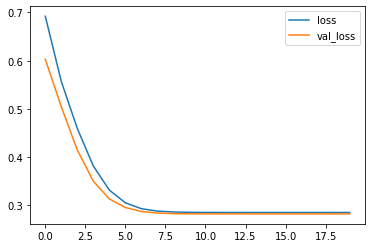

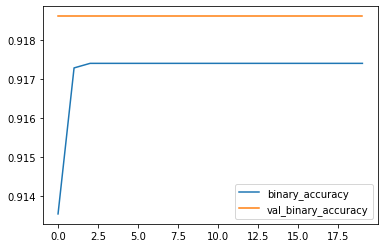

In [18]:
# pretrained_base = tf.keras.models.load_model(
#     '../input/cv-course-models/cv-course-models/vgg16-pretrained-base',
# )
# pretrained_base.trainable = False


# model = keras.Sequential([
#     pretrained_base,
#     layers.Flatten(),
#     layers.Dense(6, activation='relu'),
#     layers.Dense(1, activation='sigmoid'),
# ])

# model = keras.Sequential([
#     layers.Dense(5, activation='relu', input_shape=[9000]),
#     layers.Dense(10, activation='relu'),    
#     layers.Dense(2, activation='sigmoid'),
# ])
model = keras.Sequential([

    # First Convolutional Block
    layers.Conv1D(filters=10, kernel_size=5, activation="relu", padding='same',   #the filter size i chose is random in each layer so far
                  # give the input dimensions in the first layer
                  input_shape=[9000,1]),                                        #i am a little confused about input shape and if thats right
    layers.MaxPool1D(),

    # Second Convolutional Block
    layers.Conv1D(filters=10, kernel_size=3, activation="relu", padding='same'),
    layers.MaxPool1D(),

    # Third Convolutional Block
    layers.Conv1D(filters=10, kernel_size=3, activation="relu", padding='same'),
    layers.MaxPool1D(),

    # Classifier Head
    layers.Flatten(),
    layers.Dense(5, activation='relu', input_shape=[9000]),                   #dense layer sizes could probably be chosen better
    layers.Dense(10, activation='relu'),    
    layers.Dense(2, activation='sigmoid'),
])
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['binary_accuracy'],
)

history = model.fit(
    X_train, Y_train,
    validation_data=(X_test, Y_test),
    epochs=20,
    verbose=1,
)

history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot();
